In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Dataset: https://figshare.com/projects/Generalized_neural_decoders_for_transfer_learning_across_participants_and_recording_modalities/90287

github (HTNet): https://github.com/BruntonUWBio/HTNet_generalized_decoding/blob/e0058d4bc67a95a59e4a51384d895d0d07c4d65b/model_utils.py#L288

In [2]:
#@title Imports
import os
import random

from scipy import signal, stats

import torch
import scipy
import pickle
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
from scipy.io import netcdf
import matplotlib.pyplot as plt

import torch.nn as nn
import sklearn.metrics
from datetime import datetime
import torch.nn.functional as F

from pathlib import Path
from copy import deepcopy
from tqdm.auto import tqdm
import torch.optim as optim
from torchsummary import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('bright')

In [3]:
#@title Plotting functions
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
#@title Additional functions
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

# Shape fo the Conv2d layer output
def cout(x, layer):
  """
  Unnecessarily complicated but complete way to
  calculate the output depth, height
  and width size for a Conv2D layer

  Args:
    x: tuple
      Input size (depth, height, width)
    layer: nn.Conv2d
      The Conv2D layer

  Returns:
    Tuple of out-depth/out-height and out-width
    Output shape as given in [Ref]
    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

# Frobenius norm of the layers
def calculate_frobenius_norm(model):
  """
  Calculate Frobenius Norm per Layer

  Args:
    model: nn.module
      Neural network instance

  Returns:
    norm: float
      Norm value
    labels: list
      Targets
    ws: list
      Weights
  """

  # Initialization of variables
  norm, ws, labels = 0.0, [], []

  # Sum all the parameters
  for name, parameters in model.named_parameters():
    p = torch.sum(parameters**2)
    norm += p

    ws.append((p**0.5).cpu().detach().numpy())
    labels.append(name)

  # Take a square root of the sum of squares of all the parameters
  norm = (norm**0.5).cpu().detach().numpy()

  return norm, ws, labels

In [5]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [6]:
PATH_ROOT = Path('/content/drive/MyDrive/NMA-22/naturalistic_arm_movements_ecog')
PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"
PATH_MODEL = Path('/content/drive/MyDrive/Model parameters')

In [7]:
metadata = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)
metadata.head()

,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
0,3,3520224,3520224,r_wrist,a0f66459_5_0500.avi,2206,0,a0f66459,0.029668,"[292.4933419228, 292.4933419228, 292.493341922...",...,"[211.6673732102, 211.6988453865, 211.667373210...",0.173995,29,56.068108,-152.360333,3.133708,0,0,NaN,0
1,3,3584342,3584342,r_wrist,a0f66459_5_0501.avi,536,0,a0f66459,0.005848,"[288.1831774712, 288.1836948395, 288.183694839...",...,"[208.3187561035, 208.3187561035, 208.318756103...",0.185332,29,120.020850,-103.292387,5.215469,0,0,NaN,0
2,3,28768352,28768352,r_wrist,a0f66459_5_0711.avi,73,0,a0f66459,0.039133,"[277.4298783541, 277.6194574833, 277.619457483...",...,"[221.6612606049, 221.6737040281, 221.794342160...",0.365911,41,37.482779,147.428994,3.061077,0,0,NaN,0
3,3,28853918,28853918,r_wrist,a0f66459_5_0711.avi,2640,0,a0f66459,0.030491,"[279.3920893669, 279.3920893669, 279.392089366...",...,"[222.3323924541, 222.3482117653, 222.35734725,...",0.501548,19,35.601992,-122.635080,2.163772,0,0,NaN,0
4,3,29639049,29639049,r_wrist,a0f66459_6_0000.avi,674,0,a0f66459,0.454378,"[252.2575044632, 252.2575044632, 252.257504463...",...,"[228.3691136539, 228.3421618044, 228.038380678...",0.238979,24,94.181709,-56.404814,5.021071,19,1,3.0,0


In [8]:
data = np.load(PATH_ROI / "power-roi-all-patients.npy")
data.shape

(5984, 8, 25, 91)

### Train/test split:

In [ ]:
test_day = 3
events = metadata.day.values
#labels = metadata.reach_a.values
labels = metadata.mvmt.values == 'r_wrist'

mask_train = (events != test_day)
mask_test  = (events == test_day)

X_train, y_train = data[mask_train, :, :], np.array(labels[mask_train], dtype = int)
X_test, y_test = data[mask_test, :, :], np.array(labels[mask_test], dtype = int)

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

 X_train: (4835, 8, 25, 91) 
 X_test:  (1149, 8, 25, 91) 
 y_train: (4835,) 
 y_test:  (1149,) 


### Data loaders definition:

In [ ]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

n_roi = data.shape[1]
n_freqs = data.shape[2]
n_samples = data.shape[3]

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

 X_train: torch.Size([4835, 8, 25, 91]) 
 X_test:  torch.Size([1149, 8, 25, 91]) 
 y_train: torch.Size([4835]) 
 y_test:  torch.Size([1149]) 


### Initialize HTNet

In [ ]:
class HTNet(nn.Module):
  """
  Initialize HTNetwork
  """

  def __init__(self, n_classes, n_channels = 8, n_samples = 4835,
               input_shape = (25, 91), p_dropout = 0.5, kernel_len = 32,
               F1 = 8, F2 = 16, D = 2, norm_rate = 0.25,
               dropoutType = 'Dropout', kernel_len_sep = 8):
    """
    Initialize HTNetwork parameters

    Args:
      n_classes              : Number of classes to classify
      n_channels, n_samples  : Number of channels and samples in the input neural data
      input_shape            : Shape of the input data
      p_dropout              : Dropout fraction
      kernel_len             : Length of temporal convolution kernel in first layer
      F1, F2                 : Number of temporal filters (F1) and number of pointwise
                               filters (F2) to learn; we used F2 = F1 * D, same as EEGNet paper 
      D                      : Number of spatial filters to learn within each temporal
                               convolution
      norm_rate              : Maximum norm for dense layer weights
      dropoutType            : Either SpatialDropout2D or Dropout, passed as a string
      kernel_len_sep         : Length of temporal convolution kernel in separable convolution layer

    Returns:
      Nothing
    """
    super(HTNet, self).__init__()
    self.n_classes = n_classes
    self.n_channels = n_channels
    self.n_samples = n_samples
    self.input_shape = input_shape
    self.norm_rate = norm_rate

    self.lin_shape = np.array([n_samples, *input_shape])

    # Dropout definition
    if dropoutType == 'Dropout2d':
      dropoutType = nn.Dropout2d
    elif dropoutType == 'Dropout':
      dropoutType = nn.Dropout
    else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    # First block
    self.first_block = nn.Sequential(
        nn.Conv2d(in_channels = n_channels, out_channels = F1, 
                  kernel_size = (1, kernel_len), padding = 'same',
                  bias = False),
        nn.BatchNorm2d(F1)
    )

    # Second block
    self.second_block1 = nn.Conv2d(in_channels = F1, out_channels = F1 * D,
                                  kernel_size = (1, kernel_len // 2), bias = False,
                                  padding = 'same', groups = F1)
    self.second_block2 = nn.Sequential(
        nn.BatchNorm2d(F1 * D),
        nn.ELU()
    )

    # Third block
    self.third_block = nn.Sequential(
        nn.AvgPool2d(kernel_size = 2),
        dropoutType(p = p_dropout)
    )
    
    self.lin_shape[1:] = self.lin_shape[1:] // 2

    # Fourth block
    self.fourth_block = nn.Sequential(
        nn.Conv2d(in_channels = F1 * D, out_channels = F1 * D,
                  kernel_size = (1, kernel_len_sep), bias = False,
                  padding = 'same', groups = F1 * D),
        nn.Conv2d(in_channels = F1 * D, out_channels = F2,
                  kernel_size = 1, bias = False,
                  padding = 'same'),
        nn.BatchNorm2d(F2),
        nn.ELU()
    )

    self.lin_shape[0] = F2

    # Fifth block
    self.fifth_block = nn.Sequential(
        nn.AvgPool2d(kernel_size = 2),
        dropoutType(p = p_dropout)
    )

    self.lin_shape[1:] = self.lin_shape[1:] // 2

    # Linear block
    self.linear = nn.Linear(in_features = np.prod(self.lin_shape).astype(int),
                            out_features = n_classes)

  def forward(self, x):
    x = self.first_block(x)

    x = self.second_block1(x)
    self.second_block1.weight.data = self.second_block1.weight.data.clamp(min = -self.norm_rate,
                                                                          max = self.norm_rate)
    x = self.second_block2(x)

    x = self.third_block(x)
    x = self.fourth_block(x)
    x = self.fifth_block(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.linear(x)
    x = F.log_softmax(x, dim = 1)
    
    return x

### Model characteristics

In [ ]:
# Initialize model
model = HTNet(n_classes = 2).float().to(DEVICE)
print(model)

# Print torchsummary
print(summary(model, input_size = (8, 25, 91)))

# Test model.forward(x_sample)
print(f"Model {model.__class__.__name__} test succesffull")

HTNet(
  (first_block): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 32), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (second_block1): Conv2d(8, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=8, bias=False)
  (second_block2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ELU(alpha=1.0)
  )
  (third_block): Sequential(
    (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (1): Dropout(p=0.5, inplace=False)
  )
  (fourth_block): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 8), stride=(1, 1), padding=same, groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
  )
  (fifth_block): Sequential(
    (0): AvgPool2d(kernel_size=2, stride=2, padding

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


### Frobenius norm for the weights

In [ ]:
def calculate_frobenius_norm(model):
  """
  Calculate Frobenius Norm per Layer

  Args:
    model: nn.module
      Neural network instance

  Returns:
    norm: float
      Norm value
    labels: list
      Targets
    ws: list
      Weights
  """

  # Initialization of variables
  norm, ws, labels = 0.0, [], []

  # Sum all the parameters
  for name, parameters in model.named_parameters():
    p = torch.sum(parameters**2)
    norm += p

    ws.append((p**0.5).cpu().detach().numpy())
    labels.append(name)

  # Take a square root of the sum of squares of all the parameters
  norm = (norm**0.5).cpu().detach().numpy()

  return norm, ws, labels

### Train


In [ ]:
def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current input model using the data
  from Train_loader and Updates parameters for a single pass

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Input dataset
    optimizer: function
      Optimizer
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    model: nn.module
      Neural network instance post training
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    if reg_function1 is None:
      weight = torch.Tensor([1/torch.sum(torch.abs(target - 1)), 1/torch.sum(target)]).to(device)
      loss = criterion(output, target, weight = weight) # Weight due to the unbalanced classes
    elif reg_function2 is None:
      loss = criterion(output, target, weight = weight)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target, weight = weight) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model

### Test

In [ ]:
def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  """
  Tests the current model

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    test_loader: torch.loader
      Test dataset
    criterion: function
      Specifies loss function [default: nll_loss]

  Returns:
    test_acc: float
    test_loss: float
      Test loss
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction = 'sum').item()  # Sum up batch loss
      pred = output.argmax(dim = 1, keepdim = True)  # Get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc = 100. * correct / len(test_loader.dataset)
  return (test_acc, test_loss)

### Run the model

In [ ]:
def run_nn(args, model, train_loader, val_loader,
           reg_function1=None, reg_function2=None):
  """
  Trains the model with train_loader and
  tests the learned model using val_loader

  Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]

  Returns:
    val_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    param_norm_list: list
      Log of frobenius norm
    trained_model: nn.module
      Trained model/model post training
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=args['lr'])

  best_acc = 0
  val_acc_list, train_acc_list, val_loss_list, train_loss_list, param_norm_list = [], [], [], [], []
  for epoch in tqdm(range(args['epochs']), desc = 'Epochs'):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc, train_loss = test(trained_model, train_loader, device=device)
    val_acc, val_loss = test(trained_model, val_loader, device=device)
    param_norm, param_norm_layers, labels = calculate_frobenius_norm(trained_model)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_state = deepcopy(model.state_dict())

    if (epoch + 1) % 10 == 0:
      print(f'Train accuracy on epoch {epoch + 1}: {train_acc}')
      print(f'Validation accuracy on epoch {epoch + 1}: {val_acc}\n')
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    param_norm_list.append(param_norm)
    
  now = datetime.now()
  date_time = now.strftime("%m %d %Y %H:%M:%S")
  torch.save(best_model_state, str(PATH_MODEL) +  f'/state_dict_model_{round(best_acc, 5)}_{date_time}.pt')
  torch.save(deepcopy(optimizer.state_dict()), str(PATH_MODEL) + f'/state_dict_optim_{round(best_acc, 5)}_{date_time}.pt')

  return val_acc_list, train_acc_list, val_loss_list, train_loss_list,\
          best_model_state, param_norm_list, param_norm_layers, labels

In [ ]:
args = {'epochs': 50, 
        'device': DEVICE, 
        'lr': 1e-3}

val_acc_list, train_acc_list, val_loss_list, train_loss_list,\
best_model_state, param_norm_list, param_norm_layers, labels = run_nn(args, model, train_loader, test_loader)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Train accuracy on epoch 10: 94.68459152016545
Validation accuracy on epoch 10: 95.9094865100087

Train accuracy on epoch 20: 97.89038262668045
Validation accuracy on epoch 20: 98.69451697127937

Train accuracy on epoch 30: 99.60703205791107
Validation accuracy on epoch 30: 99.21671018276763

Train accuracy on epoch 40: 99.68976215098242
Validation accuracy on epoch 40: 99.04264577893821

Train accuracy on epoch 50: 99.58634953464323
Validation accuracy on epoch 50: 98.52045256744995



In [ ]:
datetime = datetime.now()
datetime_temp = datetime.strftime("%m %d %Y %H:%M:%S")
with open(str(PATH_MODEL) + f'/plots_data_{datetime_temp}.pickle', 'wb') as f:
  pickle.dump(val_acc_list, f)
  pickle.dump(train_acc_list, f)
  pickle.dump(val_loss_list, f)
  pickle.dump(train_loss_list, f)
  pickle.dump(param_norm_list, f)
  pickle.dump(param_norm_layers, f)
  pickle.dump(labels, f)

### Plots

In [ ]:
datetime_temp = '07 27 2022 08:46:03'
with open(str(PATH_MODEL) + f'/plots_data_{datetime_temp}.pickle', 'rb') as f:
  val_acc_list = pickle.load(f)
  train_acc_list = pickle.load(f)
  val_loss_list = pickle.load(f)
  train_loss_list = pickle.load(f)
  param_norm_list = pickle.load(f)
  param_norm_layers = pickle.load(f)
  labels = pickle.load(f)

In [ ]:
model_char = '99.56484_07 27 2022 08:46:03'
best_model_state = torch.load(str(PATH_MODEL) + f'/state_dict_model_{model_char}.pt',
                              map_location=torch.device('cpu'))
best_model = HTNet(n_classes = 2).cpu()
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
best_model.eval()
train_y_score = torch.exp(best_model(X_train)).detach().numpy()
pred_train = np.argmax(train_y_score, axis = 1)
conf_matr_train = sklearn.metrics.confusion_matrix(y_train, pred_train)

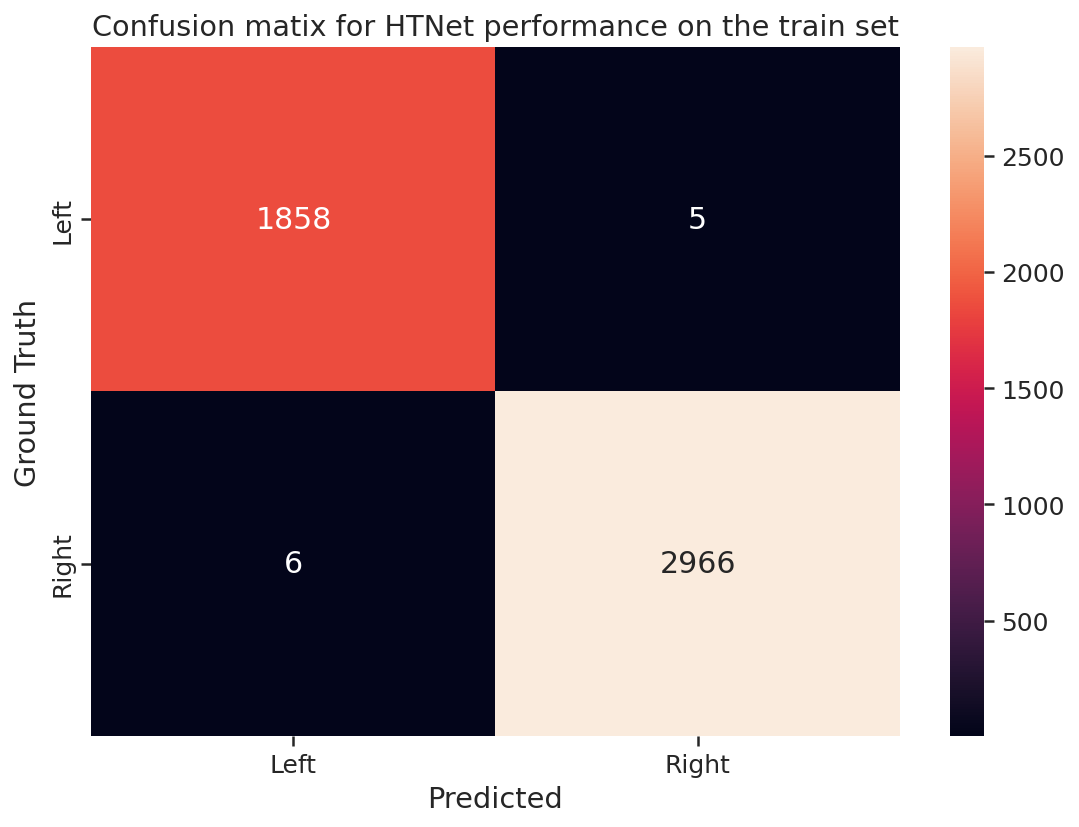

In [ ]:
sns.heatmap(conf_matr_train, annot = True, xticklabels = ['Left', 'Right'],
            yticklabels = ['Left', 'Right'], fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion matix for HTNet performance on the train set')
plt.plot();

plt.savefig(str(PATH_MODEL) + '/conf_matr_train.png')

In [ ]:
test_y_score = torch.exp(best_model(X_test)).detach().numpy()
pred_test = np.argmax(test_y_score, axis = 1)
conf_matr_test = sklearn.metrics.confusion_matrix(y_test, pred_test)

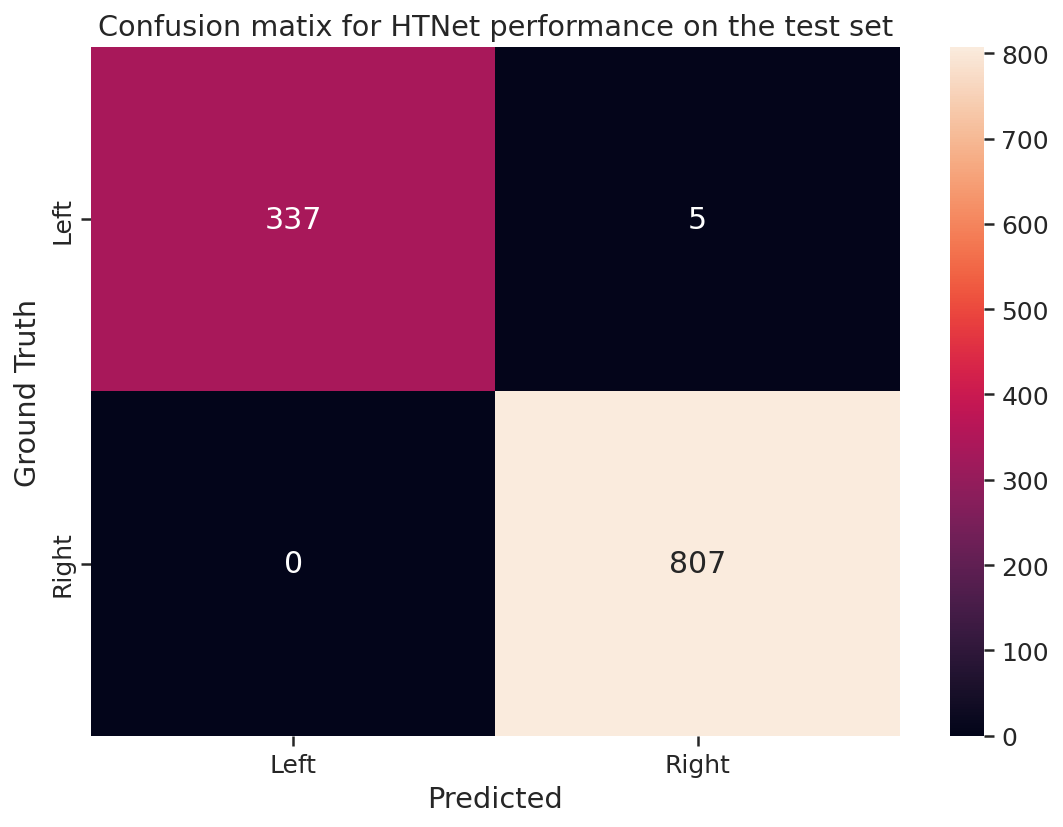

In [ ]:
sns.heatmap(conf_matr_test, annot = True, xticklabels = ['Left', 'Right'],
            yticklabels = ['Left', 'Right'], fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion matix for HTNet performance on the test set')
plt.plot();

plt.savefig(str(PATH_MODEL) + '/conf_matr_test.png')

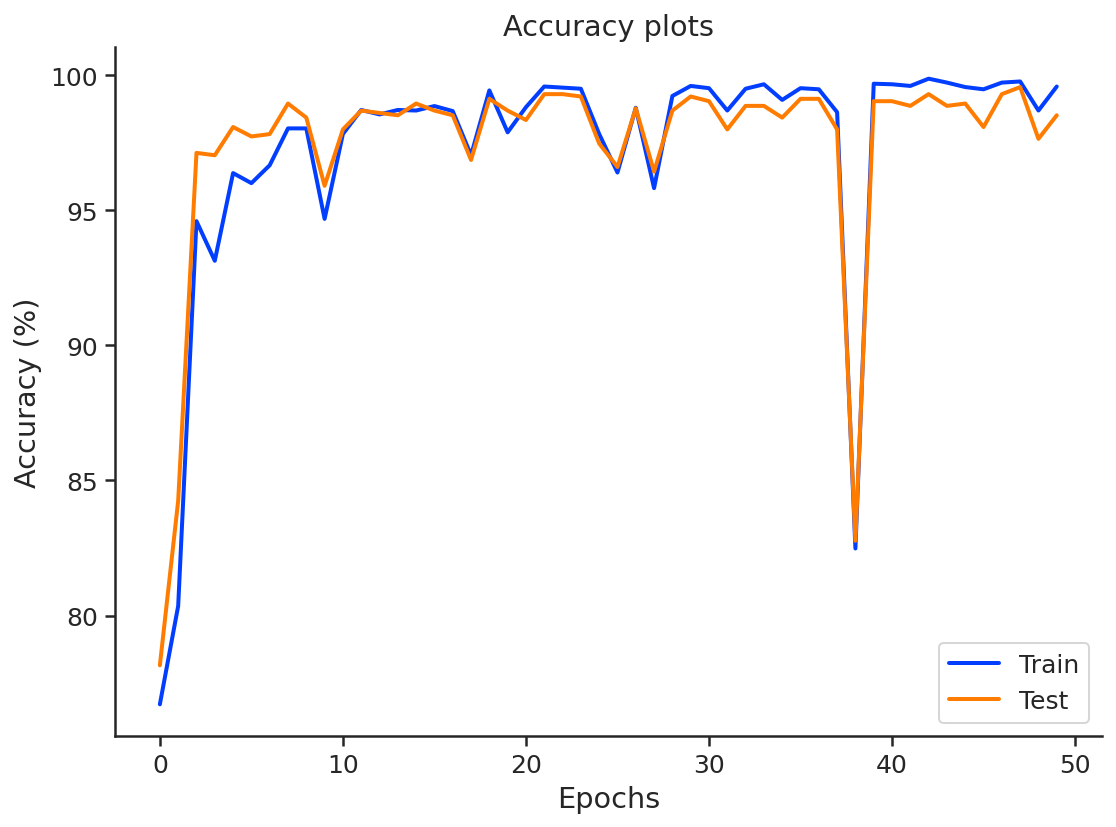

In [ ]:
epochs = 50
plt.plot(np.arange(epochs), train_acc_list, label = 'Train', linewidth = 2)
plt.plot(np.arange(epochs), val_acc_list, label = 'Test', linewidth = 2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy plots')
plt.legend()
plt.plot();

plt.savefig(str(PATH_MODEL) + '/accuracy.png')

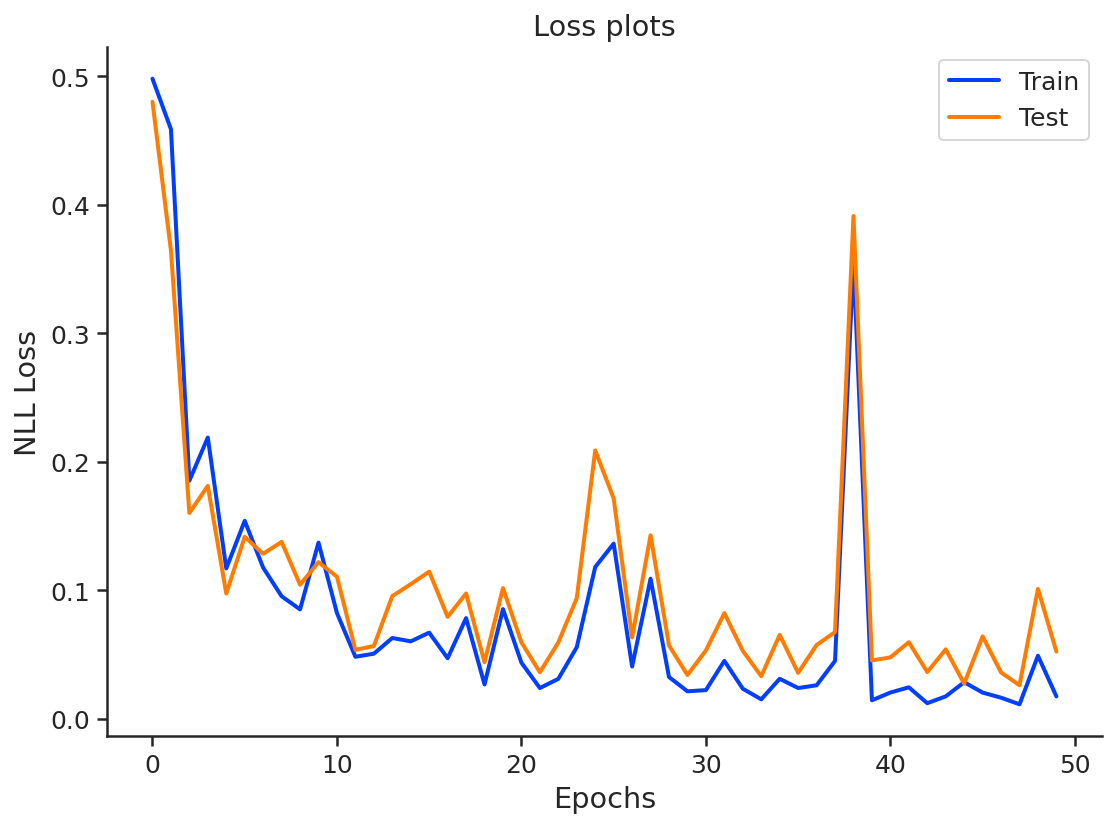

In [ ]:
epochs = 50
plt.plot(np.arange(epochs), train_loss_list, label = 'Train', linewidth = 2)
plt.plot(np.arange(epochs), val_loss_list, label = 'Test', linewidth = 2)
plt.xlabel('Epochs')
plt.ylabel('NLL Loss')
plt.title('Loss plots')
plt.legend()
plt.plot();

plt.savefig(str(PATH_MODEL) + '/loss.png')

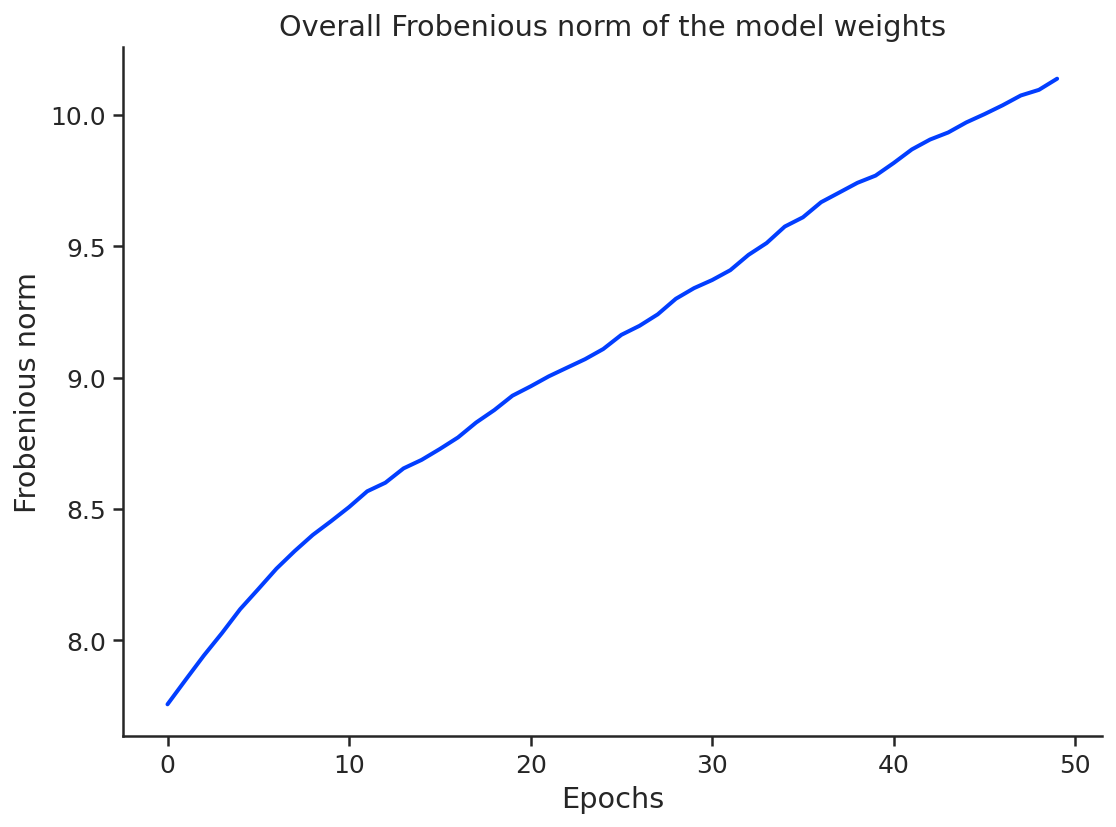

In [ ]:
epochs = 50
plt.plot(np.arange(epochs), param_norm_list, linewidth = 2)
plt.xlabel('Epochs')
plt.ylabel('Frobenious norm')
plt.title('Overall Frobenious norm of the model weights')
plt.plot();

plt.savefig(str(PATH_MODEL) + '/frobenious_norm.png')

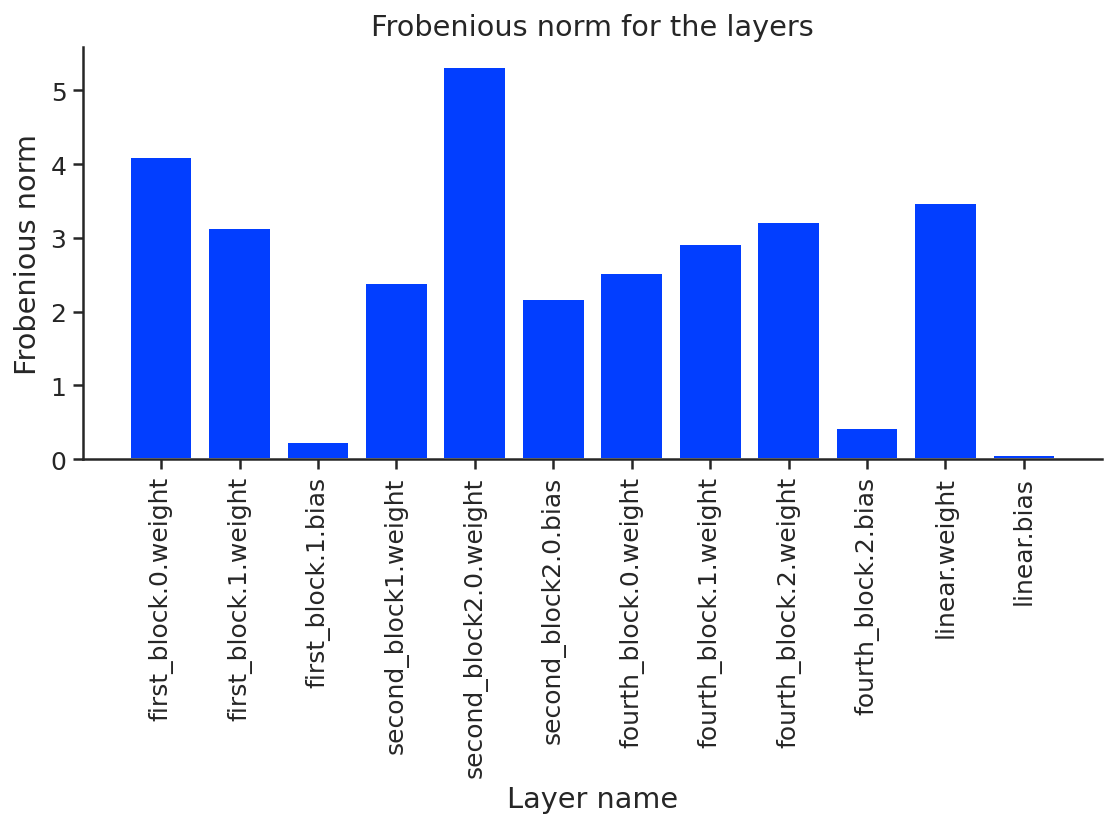

In [ ]:
plt.bar(labels, param_norm_layers)
plt.xticks(rotation = 'vertical')
plt.xlabel('Layer name')
plt.ylabel('Frobenious norm')
plt.title('Frobenious norm for the layers')
plt.plot();

plt.savefig(str(PATH_MODEL) + '/layer_frobenious_norm.png')

In [ ]:
recall = sklearn.metrics.recall_score(y_test, pred_test)
precision = sklearn.metrics.precision_score(y_test, pred_test)
roc_auc = sklearn.metrics.roc_auc_score(y_test, test_y_score[:, 1])

print('Recall of the model on the test set: ', recall)
print('Precision of the model on the test set: ', precision)
print('ROC AUC Score of the model on the test set: ', roc_auc)

Recall of the model on the test set:  1.0
Precision of the model on the test set:  0.9938423645320197
ROC AUC Score of the model on the test set:  0.9990579505351566


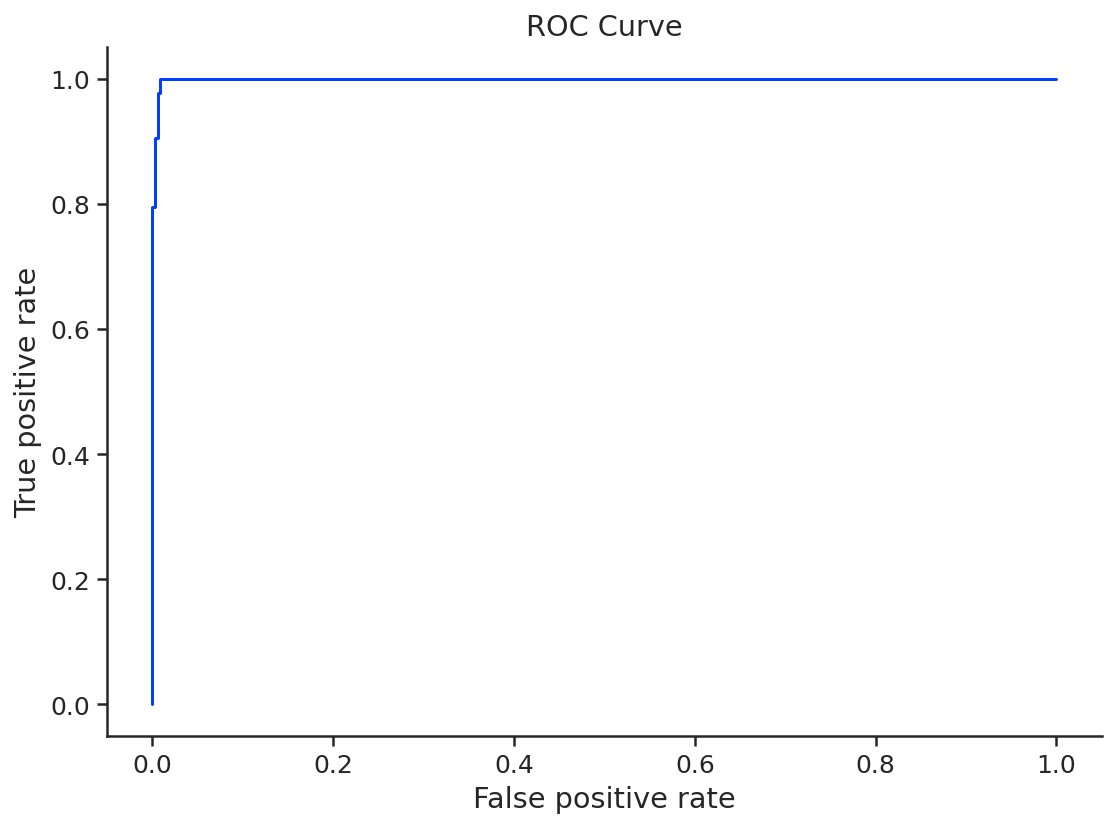

In [ ]:
fpr, tpr, thresh = sklearn.metrics.roc_curve(y_test, test_y_score[:, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.plot(fpr, tpr);

plt.savefig(str(PATH_MODEL) + '/roc_curve.png')

### Dataset analysis


In [ ]:
r_wrist = metadata[metadata['mvmt'] == 'r_wrist']
l_wrist = metadata[metadata['mvmt'] == 'l_wrist']

In [ ]:
r_wrist.head()

,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
0,3,3520224,3520224,r_wrist,a0f66459_5_0500.avi,2206,0,a0f66459,0.029668,"[292.4933419228, 292.4933419228, 292.493341922...",...,"[211.6673732102, 211.6988453865, 211.667373210...",0.173995,29,56.068108,-152.360333,3.133708,0,0,NaN,0
1,3,3584342,3584342,r_wrist,a0f66459_5_0501.avi,536,0,a0f66459,0.005848,"[288.1831774712, 288.1836948395, 288.183694839...",...,"[208.3187561035, 208.3187561035, 208.318756103...",0.185332,29,120.020850,-103.292387,5.215469,0,0,NaN,0
2,3,28768352,28768352,r_wrist,a0f66459_5_0711.avi,73,0,a0f66459,0.039133,"[277.4298783541, 277.6194574833, 277.619457483...",...,"[221.6612606049, 221.6737040281, 221.794342160...",0.365911,41,37.482779,147.428994,3.061077,0,0,NaN,0
3,3,28853918,28853918,r_wrist,a0f66459_5_0711.avi,2640,0,a0f66459,0.030491,"[279.3920893669, 279.3920893669, 279.392089366...",...,"[222.3323924541, 222.3482117653, 222.35734725,...",0.501548,19,35.601992,-122.635080,2.163772,0,0,NaN,0
4,3,29639049,29639049,r_wrist,a0f66459_6_0000.avi,674,0,a0f66459,0.454378,"[252.2575044632, 252.2575044632, 252.257504463...",...,"[228.3691136539, 228.3421618044, 228.038380678...",0.238979,24,94.181709,-56.404814,5.021071,19,1,3.0,0


In [ ]:
l_wrist.head()

,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
659,3,21619369,21619369,l_wrist,c95c1e82_3_0631.avi,2885,0,c95c1e82,0.283533,"[264.8023934364, 264.849316597, 264.849316597,...",...,"[232.860701561, 232.8546319008, 232.9045629501...",0.411521,34,61.537642,16.183750,2.369654,25,1,-25.0,1
660,3,33009103,33009103,l_wrist,c95c1e82_4_0028.avi,529,0,c95c1e82,0.464553,"[329.5503776073, 329.5503776073, 329.550377607...",...,"[263.6012084484, 263.6012084484, 263.601208448...",0.312617,31,102.394710,-130.891064,2.995417,28,1,3.0,1
661,3,33040369,33040369,l_wrist,c95c1e82_4_0028.avi,1467,0,c95c1e82,0.012118,"[199.2791831493, 199.2791831493, 199.279183149...",...,"[211.4432239532, 211.4432239532, 211.443223953...",0.277066,19,79.892234,-159.349458,3.835347,0,0,NaN,1
662,3,33152040,33152040,l_wrist,c95c1e82_4_0029.avi,1217,0,c95c1e82,0.100704,"[226.7225420475, 226.7173850536, 226.674785018...",...,"[220.5590441227, 220.5379295945, 220.492052286...",0.274112,37,81.230354,170.909418,6.198310,19,1,18.0,1
663,3,33577599,33577599,l_wrist,c95c1e82_4_0032.avi,3170,0,c95c1e82,0.050232,"[261.5709636211, 261.6716566086, 261.794334530...",...,"[193.3203325272, 193.2419676781, 193.241967678...",0.385255,36,24.983544,-134.209752,0.894954,0,0,NaN,1


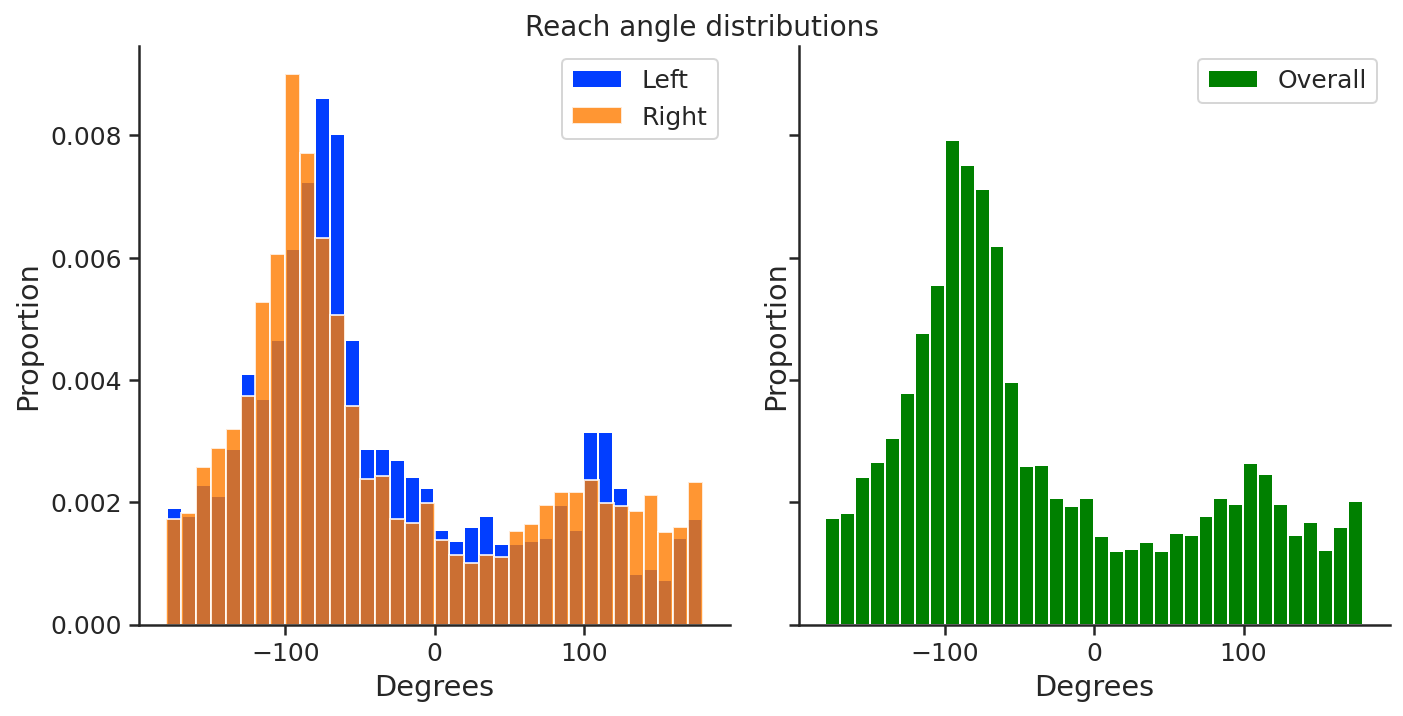

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), nrows = 1, ncols = 2, sharex = True,
                       sharey = True)
ax[0].hist(x = l_wrist['reach_a'], density = True, bins = 36, label = 'Left')
ax[0].hist(x = r_wrist['reach_a'], density = True, bins = 36, label = 'Right',
           alpha = 0.8)
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Proportion')
ax[0].legend()

ax[1].hist(x = metadata['reach_a'], density = True, bins = 36, label = 'Overall',
           color = 'green')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Proportion')
ax[1].legend()

fig.suptitle('Reach angle distributions', y = 1.0, fontsize = 14)
plt.plot();

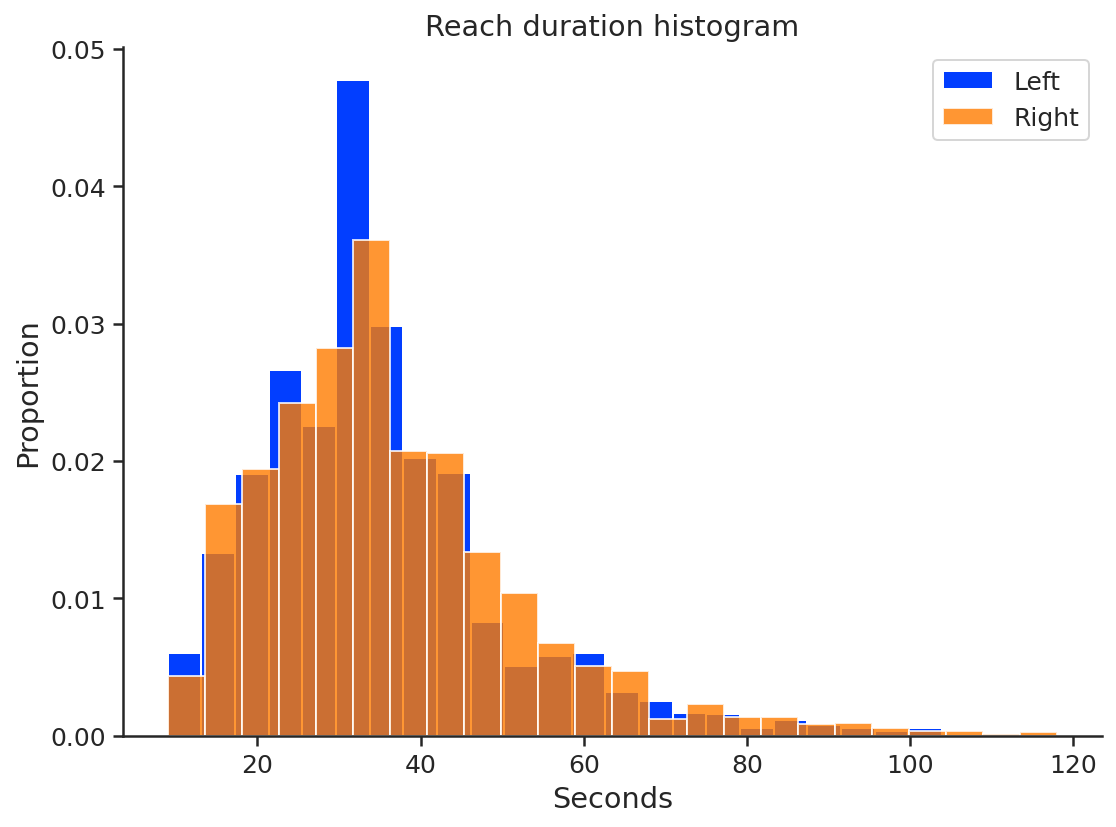

In [ ]:
plt.hist(x = l_wrist['reach_duration'], density = True, label = 'Left', bins = 24)
plt.hist(x = r_wrist['reach_duration'], density = True, label = 'Right', alpha = 0.8, bins = 24)
plt.xlabel('Seconds')
plt.ylabel('Proportion')
plt.title('Reach duration histogram')
plt.legend()
plt.plot();

In [ ]:
metadata[['mvmt', 'reach_a']].groupby(by = 'mvmt').agg(['mean', 'std', 'min', 'max'])

reach_a                                   
              mean        std         min         max
mvmt                                                 
l_wrist -34.084495  90.256618 -179.326219  179.086682
r_wrist -33.010501  97.781822 -179.881324  179.798287

In [ ]:
metadata[['mvmt', 'reach_a']].groupby(by = 'mvmt').arg()

In [ ]:
scipy.stats.ttest_ind(r_wrist['reach_a'], l_wrist['reach_a'])

Ttest_indResult(statistic=0.42151805506759965, pvalue=0.6733919753742901)

=> We don't reject the null hypothesis that the mean angle of the wrists is equal

In [ ]:
scipy.stats.ks_2samp(r_wrist['reach_a'], l_wrist['reach_a'])

KstestResult(statistic=0.08389206613226573, pvalue=5.610325426452789e-09)

=> We reject the null hypothesis that the samples come from the same distribution

In [12]:
metadata[['patient_index', 'mvmt', 'reach_a']].groupby(by = ['patient_index', 'mvmt']).agg(['mean', 'std', 'min', 'max'])

reach_a                                    
                            mean         std         min         max
patient_index mvmt                                                  
0             r_wrist -31.359964   97.587806 -179.732653  179.798287
1             l_wrist -25.467301  115.371326 -176.890784  179.086682
2             r_wrist -39.486738   92.963595 -178.794957  179.584053
3             l_wrist -59.490931   81.135808 -179.200019  176.770640
4             l_wrist -36.800229  100.066643 -176.904115  177.404785
5             r_wrist -39.148875  101.164458 -179.252704  179.795000
6             l_wrist -33.377900   80.452323 -178.741610  175.941823
7             l_wrist -28.105349   89.641020 -179.326219  179.002604
8             r_wrist -18.331455   97.966195 -177.106873  178.871669
9             r_wrist -11.577915  102.987113 -175.975258  179.352470
10            r_wrist -41.354333   91.485076 -179.881324  179.695472